<a href="https://colab.research.google.com/github/MashaMihalkova/Gender_identifikation/blob/main/Gender_ident.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание

Система распознавания пола диктора

Нужно обучить модель распознавания пола диктора.
В файле f.txt перечислены женские голоса, в файле m.txt мужские голоса.
В папке wav_data аудио файлы в формате PCM 8000 Гц, 16 бит.

Помимо *.ipynb, необходимо добавить test_gender.py, 
который позволит распознавать отдельный wav файл

Код оформить на github.com

# Модель

Epoch 1/100
2/2 [==============================] - 1s 158ms/step - loss: 27.3818 - accuracy: 0.5246 - val_loss: 3.8789 - val_accuracy: 0.5122

Epoch 00001: val_loss improved from inf to 3.87890, saving model to /content/drive/MyDrive/iden_gender/my_model3.h5
Epoch 2/100
2/2 [==============================] - 0s 20ms/step - loss: 18.2194 - accuracy: 0.5164 - val_loss: 4.8627 - val_accuracy: 0.5732

Epoch 00002: val_loss did not improve from 3.87890
Epoch 3/100
2/2 [==============================] - 0s 17ms/step - loss: 10.7964 - accuracy: 0.6557 - val_loss: 1.7030 - val_accuracy: 0.7073

Epoch 00003: val_loss improved from 3.87890 to 1.70298, saving model to /content/drive/MyDrive/iden_gender/my_model3.h5
Epoch 4/100
2/2 [==============================] - 0s 18ms/step - loss: 12.6429 - accuracy: 0.5328 - val_loss: 2.2124 - val_accuracy: 0.6341

Epoch 00004: val_loss did not improve from 1.70298
Epoch 5/100
2/2 [==============================] - 0s 20ms/step - loss: 8.1810 - accuracy: 0.

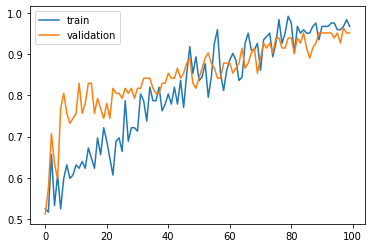

In [9]:
import os
import keras
import librosa
import numpy as np
import matplotlib.pyplot as plt
from keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM, Activation, BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.callbacks import ModelCheckpoint

DATA = '/content/drive/MyDrive/iden_gender/data.npy'
TARGET = '/content/drive/MyDrive/iden_gender/target.npy'

def load_label(label_path):
  label = os.listdir(label_path)
  return label

def wav2mfcc(path, max_pad_size=11):
  y, sr = librosa.load(path=path, sr=None, mono=1)
  y = y[::3]
  audio_mac = librosa.feature.mfcc(y=y, sr=8000)
  y_shape = audio_mac.shape[1]
  if y_shape < max_pad_size:
      pad_size = max_pad_size - y_shape
      audio_mac = np.pad(audio_mac, ((0, 0), (0, pad_size)), mode='constant')
  else:
      audio_mac = audio_mac[:, :max_pad_size]
  return audio_mac
def save_data_to_array(label_path, max_pad_size=11):
    mfcc_vectors = []
    target = []
    labels = load_label(label_path=label_path)
    for i, label in enumerate(labels):
        path = label_path + '/' + label
        wavfiles = [path + '/' + file for file in os.listdir(path)]
        for wavfile in wavfiles:
          
            wav = wav2mfcc(wavfile, max_pad_size=max_pad_size)
            mfcc_vectors.append(wav)
            target.append(i)
    np.save(DATA, mfcc_vectors)
    np.save(TARGET, target)

def save_data_to_array(label_path, max_pad_size=11):
  mfcc_vectors = []
  target = []
  labels = load_label(label_path=label_path)
  for i, label in enumerate(labels):
      path = label_path + '/' + label
      wavfiles = [path + '/' + file for file in os.listdir(path)]
      for wavfile in wavfiles:
          wav = wav2mfcc(wavfile, max_pad_size=max_pad_size)
          mfcc_vectors.append(wav)
          target.append(i)
  np.save(DATA, mfcc_vectors)
  np.save(TARGET, target)
  # return mfcc_vectors, target

def get_train_test(split_ratio=.6, random_state=42):
  X = np.load(DATA)
  y = np.load(TARGET)
  assert X.shape[0] == y.shape[0]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1 - split_ratio), random_state=random_state,
                                                      shuffle=True)
  return X_train, X_test, y_train, y_test


def main():
 
  x_train, x_test, y_train, y_test = get_train_test()
  inp = Input(shape=(x_train.shape[1], x_train.shape[2]))
  x_train = x_train.reshape(-1, 220)
  x_test = x_test.reshape(-1, 220)
  y_train_hot = to_categorical(y_train)
  y_test_hot = to_categorical(y_test)
  
  model = Sequential()
  model.add(Dense(64, activation='relu', input_shape=(220,)))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax'))

  model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=optimizers.RMSprop(),
                metrics=['accuracy'])
  modelcheckpoint = ModelCheckpoint('/content/drive/MyDrive/iden_gender/my_model3.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
  history = model.fit(x_train, y_train_hot, batch_size=100, epochs=100, verbose=1,callbacks=[modelcheckpoint],
                      validation_data=(x_test, y_test_hot))
  
  plot_history(history)
  # model.save('/content/drive/MyDrive/iden_gender/my_model3.h5')  #  'my_model1.h5' best


def save():
  label_path = '/content/drive/MyDrive/iden_gender/'
  save_data_to_array(label_path, max_pad_size=11)


def plot_history(history):
  plt.plot(history.history['accuracy'],label='train')
  plt.plot(history.history['val_accuracy'],label='validation')
  plt.legend()
  plt.show()


if __name__ == "__main__":
  save_data_to_array("/content/drive/MyDrive/iden_gender/GENDER/", max_pad_size=11) 
  main()


# Предсказание

In [13]:
import wave
import numpy as np
import os
from keras.models import load_model

def wav2mfcc(path, max_pad_size=11):
  y, sr = librosa.load(path=path, sr=None, mono=1)
  y = y[::3]
  audio_mac = librosa.feature.mfcc(y=y, sr=8000)
  y_shape = audio_mac.shape[1]
  if y_shape < max_pad_size:
      pad_size = max_pad_size - y_shape
      audio_mac = np.pad(audio_mac, ((0, 0), (0, pad_size)), mode='constant')
  else:
      audio_mac = audio_mac[:, :max_pad_size]
  return audio_mac




if __name__ == '__main__':

    model = load_model('/content/drive/MyDrive/iden_gender/my_model3.h5') 
    wavs=[]
    wavs.append(wav2mfcc("/content/drive/MyDrive/iden_gender/inner_test/Sound_22123.wav",11))
    X=np.array(wavs)
    X= X.reshape(-1, 220)
 
    result=model.predict(X[0:1])[0] # 
    print("Результат предсказания",result)
    
    name = ["male","female"] # Создать набор меток так же, как при обучении
    ind=0 
    for i in range(len(result)):
        if result[i] > result[ind]:
            ind=1
    print("Пол:",name[ind])


Результат предсказания [8.761137e-05 9.999124e-01]
Пол: female


вызов скрипта

In [14]:
!python3 '/content/drive/MyDrive/iden_gender/test_gender.py' \
      -m "/content/drive/MyDrive/iden_gender/my_model1.h5" \
      -f "/content/drive/MyDrive/iden_gender/inner_test/Sound_22123.wav"

2021-10-11 14:46:21.685875: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-11 14:46:21.685921: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (b13b5094af8e): /proc/driver/nvidia/version does not exist
2021-10-11 14:46:22.107872: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Prediction result [9.9989653e-01 1.0346672e-04]
Gender: male
